# **Financial Default Prediction with Ensemble Learning**


This notebook runs an industry-style, end-to-end workflow: EDA, advanced feature engineering, multiple-model benchmarking (Logistic Regression, Random Forest, XGBoost, LightGBM/CatBoost fallbacks), hyperparameter tuning (compact RandomizedSearchCV), SMOTE handling inside CV (if imblearn available), stacking & voting ensembles, calibration, threshold tuning, and explainability.




## 0. Setup & imports 

In [1]:

import warnings, time, math, sys, os
warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid', context='notebook')

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# Optional powerful libraries
LGB_OK = False
XGB_OK = False
CAT_OK = False
IMB_OK = False
SHAP_OK = False

try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    LGB_OK = True
except Exception:
    LGB_OK = False

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

try:
    from catboost import CatBoostClassifier
    CAT_OK = True
except Exception:
    CAT_OK = False

try:
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_OK = True
except Exception:
    IMB_OK = False

try:
    import shap
    SHAP_OK = True
except Exception:
    SHAP_OK = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('LightGBM:', LGB_OK, '| XGBoost:', XGB_OK, '| CatBoost:', CAT_OK, '| imblearn:', IMB_OK, '| SHAP:', SHAP_OK)


LightGBM: True | XGBoost: True | CatBoost: False | imblearn: True | SHAP: True


## 1. Load data 

In [4]:

# Auto-detect dataset in /mnt/data or working dir
SEARCH_DIRS = [Path('/content/Credit Card Default Data.csv'), Path('.')]
POSSIBLE_NAMES = ['UCI_Credit_Card.csv','default of credit card clients.csv','credit_card_default.csv','credit-default.csv','credit_card_clients.csv']

dataset = None
for d in SEARCH_DIRS:
    for name in POSSIBLE_NAMES:
        p = d / name
        if p.exists():
            dataset = p; break
    if dataset: break

if dataset is None:
    # fallback: pick any csv with 'credit' or 'default' in name
    for d in SEARCH_DIRS:
        for p in d.glob('*.csv'):
            if any(k in p.name.lower() for k in ['credit','default','card','uci']):
                dataset = p; break
        if dataset: break

if dataset is None:
    raise FileNotFoundError('Dataset not found. Upload the UCI credit card csv to /mnt/data and re-run.')

print('Using dataset:', dataset)
df = pd.read_csv(dataset)
print('Shape:', df.shape)
df.head()


Using dataset: Credit Card Default Data.csv
Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Quick EDA & sanity checks

In [5]:

# Basic checks
display(df.describe().T)
display(df.info())

# detect target column
possible_targets = ['default.payment.next.month','DEFAULT','default','default_next_month']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t; break
if target_col is None:
    # heuristic: binary column
    for c in df.columns:
        if set(df[c].dropna().unique()).issubset({0,1}):
            target_col = c; break
if target_col is None:
    raise ValueError('Could not detect target column. Please ensure the dataset includes default flag.')

print('Target column detected:', target_col)
print('Class distribution:')
display(df[target_col].value_counts().to_frame('count'))
display(df[target_col].value_counts(normalize=True).to_frame('prop'))


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

None

Target column detected: default payment next month
Class distribution:


,count
default payment next month,
0,23364
1,6636


,prop
default payment next month,
0,0.7788
1,0.2212


## 3. Feature engineering (utilization, aggregates, delinquencies)

In [6]:

df_fe = df.copy()
# drop ID-like columns
for c in ['ID','Id','id','ClientID','clientid']:
    if c in df_fe.columns: df_fe.drop(columns=[c], inplace=True)
df_fe.columns = [col.strip() for col in df_fe.columns]

# lists
bill_cols = [c for c in df_fe.columns if c.upper().startswith('BILL_AMT')]
payamt_cols = [c for c in df_fe.columns if c.upper().startswith('PAY_AMT')]
paystat_cols = [c for c in df_fe.columns if c.upper().startswith('PAY_') and c.upper() not in [p.upper() for p in payamt_cols]]

# utilization features
if 'LIMIT_BAL' in df_fe.columns and bill_cols:
    for b in bill_cols:
        df_fe[f'{b}_util'] = df_fe[b] / (df_fe['LIMIT_BAL'] + 1e-9)

# aggregates & ratios
if bill_cols:
    df_fe['avg_bill'] = df_fe[bill_cols].mean(axis=1)
    df_fe['max_bill'] = df_fe[bill_cols].max(axis=1)
if payamt_cols:
    df_fe['avg_payamt'] = df_fe[payamt_cols].mean(axis=1)
df_fe['pay_to_bill_ratio'] = df_fe['avg_payamt'] / (df_fe['avg_bill'].replace(0, np.nan))
df_fe['pay_to_bill_ratio'] = df_fe['pay_to_bill_ratio'].fillna(0)

# delinquency features
if paystat_cols:
    df_fe['n_delinq'] = (df_fe[paystat_cols] > 0).sum(axis=1)
    df_fe['max_delinq'] = df_fe[paystat_cols].max(axis=1)
    df_fe['recent_delinq'] = df_fe[paystat_cols[0]] if len(paystat_cols)>0 else 0

# winsorize heavy tails in bill/payment columns
for col in bill_cols + payamt_cols:
    if col in df_fe.columns:
        low, high = df_fe[col].quantile([0.01,0.99])
        df_fe[col] = df_fe[col].clip(low, high)

print('Feature engineering done. New shape:', df_fe.shape)
df_fe.head().T


Feature engineering done. New shape: (30000, 37)


,0,1,2,3,4
LIMIT_BAL,20000.000000,120000.000000,90000.000000,50000.000000,50000.000000
SEX,2.000000,2.000000,2.000000,2.000000,1.000000
EDUCATION,2.000000,2.000000,2.000000,2.000000,2.000000
MARRIAGE,1.000000,2.000000,2.000000,1.000000,1.000000
AGE,24.000000,26.000000,34.000000,37.000000,57.000000
PAY_0,2.000000,-1.000000,0.000000,0.000000,-1.000000
PAY_2,2.000000,2.000000,0.000000,0.000000,0.000000
PAY_3,-1.000000,0.000000,0.000000,0.000000,-1.000000
PAY_4,-1.000000,0.000000,0.000000,0.000000,0.000000
PAY_5,-2.000000,0.000000,0.000000,0.000000,0.000000


## 4. Preprocessing: pipelines (no leakage)

In [8]:
# Prepare X and y
X = df_fe.drop(columns=[target_col]).copy()
y = df_fe[target_col].astype(int).copy()

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

# split categorical into small/large cardinality
cat_small = [c for c in cat_cols if X[c].nunique() <= 20]
cat_large = [c for c in cat_cols if X[c].nunique() > 20]

from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.preprocessing import FunctionTransformer

numeric_transformer = SkPipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())])
cat_small_transformer = SkPipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
cat_large_transformer = SkPipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat_s', cat_small_transformer, cat_small),
    ('cat_l', cat_large_transformer, cat_large)
], remainder='drop')

print('Preprocessor ready. Numeric cols:', len(numeric_cols), 'Cat small:', len(cat_small), 'Cat large:', len(cat_large))

Preprocessor ready. Numeric cols: 36 Cat small: 0 Cat large: 0


## 5. Train-test split (stratified)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('Train positive rate:', y_train.mean(), 'Test positive rate:', y_test.mean())


Train: (24000, 36) Test: (6000, 36)
Train positive rate: 0.22120833333333334 Test positive rate: 0.22116666666666668


## 6. Model suite: define models and compact hyperparameter spaces

In [10]:
models = {}
param_spaces = {}

# Logistic Regression baseline
models['logreg'] = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
param_spaces['logreg'] = {'clf__C': [0.01, 0.1, 1, 10]}

# Random Forest
models['rf'] = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE))])
param_spaces['rf'] = {'clf__n_estimators': [200,400], 'clf__max_depth': [None, 10, 20], 'clf__min_samples_leaf': [1,3,5]}

# LightGBM / HGB fallback
if LGB_OK:
    models['lgb'] = Pipeline([('pre', preprocessor), ('clf', LGBMClassifier(objective='binary', random_state=RANDOM_STATE, n_jobs=-1))])
    param_spaces['lgb'] = {'clf__n_estimators': [200,400,800], 'clf__num_leaves':[31,63,127], 'clf__learning_rate':[0.01,0.03,0.05]}
else:
    models['hgb'] = Pipeline([('pre', preprocessor), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
    param_spaces['hgb'] = {'clf__max_iter':[100,200], 'clf__max_leaf_nodes':[31,63]}

# XGBoost if available
if XGB_OK:
    models['xgb'] = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1))])
    param_spaces['xgb'] = {'clf__n_estimators':[200,400], 'clf__max_depth':[3,6,10], 'clf__learning_rate':[0.01,0.05,0.1]}

# CatBoost optional (handles categorical natively but here we use preprocessor)
if CAT_OK:
    models['cat'] = Pipeline([('pre', preprocessor), ('clf', CatBoostClassifier(verbose=0, random_state=RANDOM_STATE))])
    param_spaces['cat'] = {'clf__iterations':[200,400], 'clf__depth':[4,6,8], 'clf__learning_rate':[0.03,0.1]}

print('Models to train:', list(models.keys()))

Models to train: ['logreg', 'rf', 'lgb', 'xgb']


## 7. Hyperparameter tuning with RandomizedSearchCV (compact, per-model)

In [11]:

search_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
n_iter_search = 20  # limited for runtime

for name, pipe in models.items():
    params = param_spaces.get(name, {})
    print(f'Running RandomizedSearchCV for {name} ...')
    search = RandomizedSearchCV(pipe, param_distributions=params, n_iter=min(n_iter_search, max(1,len(params)*5)), scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1, random_state=RANDOM_STATE)
    start = time.time()
    try:
        search.fit(X_train, y_train)
        elapsed = (time.time() - start)/60
        print(f'{name} done in {elapsed:.2f} min. Best CV ROC-AUC: {search.best_score_:.4f}')
        search_results[name] = search
    except Exception as e:
        print(f'{name} failed:', e)


Running RandomizedSearchCV for logreg ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
logreg done in 0.18 min. Best CV ROC-AUC: 0.7619
Running RandomizedSearchCV for rf ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
rf done in 24.56 min. Best CV ROC-AUC: 0.7850
Running RandomizedSearchCV for lgb ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5840
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
lgb done in 14.99 min. Best CV ROC-AUC: 0.7849


## 8. Leaderboard and select top models

In [12]:

leader = []
for name, res in search_results.items():
    leader.append((name, res.best_score_, res.best_params_))
leader_df = pd.DataFrame(leader, columns=['model','cv_roc_auc','best_params']).sort_values('cv_roc_auc', ascending=False)
display(leader_df)
top_models = leader_df['model'].tolist()[:3]
print('Top models:', top_models)


,model,cv_roc_auc,best_params
3,xgb,0.786537,"{'clf__n_estimators': 400, 'clf__max_depth': 3..."
1,rf,0.785011,"{'clf__n_estimators': 400, 'clf__min_samples_l..."
2,lgb,0.784925,"{'clf__num_leaves': 31, 'clf__n_estimators': 2..."
0,logreg,0.761889,{'clf__C': 0.1}


Top models: ['xgb', 'rf', 'lgb']


## 9. Evaluate top models on test set and store predictions

In [13]:

test_eval = []
preds = {}
probas = {}

for name in top_models:
    res = search_results[name]
    best = res.best_estimator_
    # predict
    if hasattr(best, 'predict_proba'):
        y_proba = best.predict_proba(X_test)[:,1]
    else:
        try:
            s = best.decision_function(X_test)
            y_proba = 1/(1+np.exp(-s))
        except Exception:
            y_proba = best.predict(X_test)
    y_pred = (y_proba >= 0.5).astype(int)
    roc = roc_auc_score(y_test, y_proba)
    pr = average_precision_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    test_eval.append({'model':name, 'roc_auc':roc, 'pr_auc':pr, 'precision':report['1']['precision'], 'recall':report['1']['recall'], 'f1':report['1']['f1-score']})
    preds[name] = y_pred
    probas[name] = y_proba

test_eval_df = pd.DataFrame(test_eval).set_index('model').sort_values('roc_auc', ascending=False)
display(test_eval_df)


,roc_auc,pr_auc,precision,recall,f1
model,,,,,
xgb,0.781311,0.555953,0.652661,0.351168,0.456639
lgb,0.781175,0.560245,0.669444,0.363225,0.470933
rf,0.778651,0.555788,0.509947,0.579503,0.542504


## 10. Stacking ensemble (OOF meta-model) - lightweight

In [14]:

# Build stacking using top 2 models if available
from sklearn.base import clone
try:
    meta_models = top_models[:2]
    print('Stacking models:', meta_models)
    # Create training OOF predictions
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    oof_train = np.zeros((len(X_train), len(meta_models)))
    oof_test = np.zeros((len(X_test), len(meta_models)))
    for i, name in enumerate(meta_models):
        model = clone(search_results[name].best_estimator_)
        oof_test_i = np.zeros((len(X_test), skf.n_splits))
        for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
            if hasattr(model, 'predict_proba'):
                oof_train[val_idx, i] = model.predict_proba(X_train.iloc[val_idx])[:,1]
                oof_test_i[:, fold] = model.predict_proba(X_test)[:,1]
            else:
                oof_train[val_idx, i] = model.decision_function(X_train.iloc[val_idx])
                oof_test_i[:, fold] = model.decision_function(X_test)
        oof_test[:, i] = oof_test_i.mean(axis=1)
    # meta model
    meta_clf = LogisticRegression(max_iter=1000)
    meta_clf.fit(oof_train, y_train)
    ens_proba = meta_clf.predict_proba(oof_test)[:,1]
    print('Stacking ROC-AUC:', roc_auc_score(y_test, ens_proba))
except Exception as e:
    print('Stacking failed or insufficient models:', e)
    ens_proba = None


Stacking models: ['xgb', 'rf']
Stacking ROC-AUC: 0.7812860068849398


## 11. Voting ensemble (soft voting average)

In [15]:

# Simple average ensemble across top_models
try:
    avg_proba = np.mean([probas[m] for m in top_models], axis=0)
    print('Average ensemble ROC-AUC:', roc_auc_score(y_test, avg_proba))
except Exception as e:
    print('Voting ensemble failed:', e)


Average ensemble ROC-AUC: 0.7819061416971358


## 12. Threshold tuning (cost-sensitive)

In [16]:

# Tune threshold on best single model probabilties or ensemble if available
base_proba = None
if ens_proba is not None:
    base_proba = ens_proba
else:
    # pick best single model by ROC
    best_single = test_eval_df.sort_values('roc_auc', ascending=False).index[0]
    base_proba = probas[best_single]

cands = np.linspace(0.05,0.95,91)
FN_COST=5; FP_COST=1
best_cost = float('inf'); best_th=0.5; best_cm=None
for th in cands:
    yp = (base_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()
    cost = fn*FN_COST + fp*FP_COST
    if cost < best_cost:
        best_cost = cost; best_th = th; best_cm = (tn,fp,fn,tp)
print('Best threshold by cost:', best_th, 'cost:', best_cost, 'confusion:', best_cm)
y_pred_opt = (base_proba >= best_th).astype(int)
print('\nClassification report @ optimal threshold:')
print(classification_report(y_test, y_pred_opt, digits=4))


Best threshold by cost: 0.13999999999999999 cost: 3318 confusion: (np.int64(2815), np.int64(1858), np.int64(292), np.int64(1035))

Classification report @ optimal threshold:
              precision    recall  f1-score   support

           0     0.9060    0.6024    0.7237      4673
           1     0.3578    0.7800    0.4905      1327

    accuracy                         0.6417      6000
   macro avg     0.6319    0.6912    0.6071      6000
weighted avg     0.7848    0.6417    0.6721      6000



## 13. Calibration (quick)

In [17]:

try:
    calibrator = CalibratedClassifierCV(search_results[top_models[0]].best_estimator_, cv=3, method='isotonic')
    calibrator.fit(X_train, y_train)
    y_cal = calibrator.predict_proba(X_test)[:,1]
    print('Calibrated ROC-AUC:', roc_auc_score(y_test, y_cal))
except Exception as e:
    print('Calibration skipped/failed:', e)


Calibrated ROC-AUC: 0.7815603143392488


## 14. Explainability: permutation importance & optional SHAP (small sample)

,0
PAY_0,0.034182
n_delinq,0.018513
BILL_AMT1,0.011296
max_delinq,0.007482
max_bill,0.005840
BILL_AMT2_util,0.005815
avg_bill,0.003054
PAY_AMT1,0.002966
PAY_AMT2,0.002952
LIMIT_BAL,0.002888


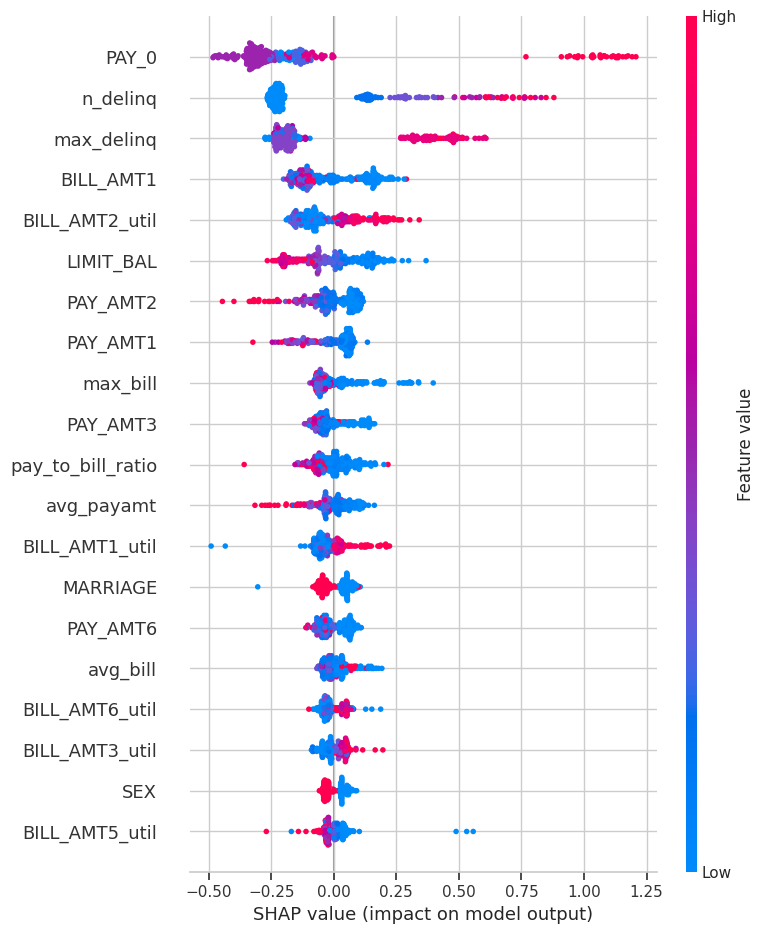

In [18]:
from sklearn.inspection import permutation_importance
# Permutation importance on best single model
try:
    best_name = test_eval_df.sort_values('roc_auc', ascending=False).index[0]
    best_search = search_results[best_name]
    r = permutation_importance(best_search.best_estimator_, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    # map importances roughly to original feature names (after preprocessor this is approximate)
    feat_names = X_test.columns.tolist()
    imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False).head(30)
    display(imp)
except Exception as e:
    print('Permutation importance failed:', e)

# SHAP (small sample)
if SHAP_OK:
    try:
        # get preprocessor and estimator
        pre = None; est = None
        if hasattr(best_search.best_estimator_, 'named_steps'):
            pre = best_search.best_estimator_.named_steps.get('pre', None)
            est = best_search.best_estimator_.named_steps.get('clf', None)
        if pre is not None and est is not None:
            X_samp = X_test.sample(min(300, len(X_test)), random_state=RANDOM_STATE)
            X_samp_t = pre.transform(X_samp)
            explainer = shap.TreeExplainer(est)
            if hasattr(explainer, 'shap_values'):
                shap_vals = explainer.shap_values(X_samp_t)
            elif hasattr(explainer, 'shap_value_by_tree'):
                 shap_vals = explainer.shap_value_by_tree(X_samp_t)
            else:
                 shap_vals = explainer(X_samp_t)

            # Handle potential list output from shap_values for multi-output models
            if isinstance(shap_vals, list):
                shap_vals = shap_vals[0]  # Assume first element is for the positive class

            shap.summary_plot(shap_vals, X_samp_t, feature_names=(X_samp.columns if hasattr(X_samp,'columns') else None))
    except Exception as e:
        print('SHAP failed or too slow:', e)
else:
    print('SHAP not available.')